<a href="https://colab.research.google.com/github/Arush0113/EEG_Pipeline-IITR/blob/main/RNNs%2C_LSTMs%2C_GRUs_and_Functional_API.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 2.x
import tensorflow as tf
print(tf.__version__)

print('GPU name: {}'.format(tf.test.gpu_device_name()))

2.5.0
GPU name: /device:GPU:0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Load and preprocess the IMDb data

In [ ]:
# A function to load and preprocess the IMDB dataset

def get_and_pad_imdb_dataset(num_words=10000, maxlen=None, index_from=2):
    from tensorflow.keras.datasets import imdb

    # Load the reviews
    (x_train, y_train), (x_test, y_test) = imdb.load_data(path='imdb.npz',
                                                          num_words=num_words,
                                                          skip_top=0,
                                                          maxlen=maxlen,
                                                          start_char=1,
                                                          oov_char=2,
                                                          index_from=index_from)

    x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        maxlen=None,
                                                        padding='pre',
                                                        truncating='pre',
                                                        value=0)
    
    x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                           maxlen=None,
                                                           padding='pre',
                                                           truncating='pre',
                                                           value=0)
    return (x_train, y_train), (x_test, y_test)

In [ ]:
# Load the dataset

(x_train, y_train), (x_test, y_test) = get_and_pad_imdb_dataset()

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [ ]:
# A function to get the dataset word index

def get_imdb_word_index(num_words=10000, index_from=2):
    imdb_word_index = tf.keras.datasets.imdb.get_word_index(
                                        path='imdb_word_index.json')
    imdb_word_index = {key: value + index_from for
                       key, value in imdb_word_index.items() if value <= num_words-index_from}
    return imdb_word_index

In [ ]:
# Get the word index

imdb_word_index = get_imdb_word_index()

In [ ]:
# Swap the keys and values of the word index

inv_imdb_word_index = {value:key for key, value in imdb_word_index.items()}

In [ ]:
# View the first dataset example sentence

list_100 = [inv_imdb_word_index[index] for index in x_train[100] if index>2]
sentence_100 = ' '.join(list_100)
sentence_100

"i am a great fan of david lynch and have everything that he's made on dvd except for hotel room the 2 hour twin peaks movie so when i found out about this i immediately grabbed it and and what is this it's a bunch of drawn black and white cartoons that are loud and foul mouthed and unfunny maybe i don't know what's good but maybe this is just a bunch of crap that was on the public under the name of david lynch to make a few bucks too let me make it clear that i didn't care about the foul language part but had to keep the sound because my neighbors might have all in all this is a highly disappointing release and may well have just been left in the box set as a curiosity i highly recommend you don't spend your money on this 2 out of 10"

In [ ]:
y_train[100]

0

#### Build an Embedding layer into a model

In [ ]:
# Get the maximum token value

max_index_value = max(imdb_word_index.values())
max_index_value

10000

In [ ]:
# Specify an embedding dimension

embedding_dim = 16

In [ ]:
# Build a model using Sequential:
#     1. Embedding layer
#     2. GlobalAveragePooling1D
#     3. Dense

model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(input_dim = max_index_value+1, output_dim=embedding_dim, mask_zero=False),
                             tf.keras.layers.GlobalAveragePooling1D(),
                             tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [ ]:
# Functional API refresher: use the Model to build the same model

inp_shape = (None, )
review_sequence = tf.keras.Input(shape = inp_shape)
embedding_sequence = tf.keras.layers.Embedding(input_dim=max_index_value+1, output_dim=embedding_dim, input_shape=(review_sequence.shape), mask_zero=False)(review_sequence)
average_embedding = tf.keras.layers.GlobalAveragePooling1D()(embedding_sequence)
positive_probability = tf.keras.layers.Dense(units=1, activation='sigmoid')(average_embedding)

model = tf.keras.Model(inputs = review_sequence, outputs = positive_probability) 

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, None)]            0         
_________________________________________________________________
embedding_7 (Embedding)      (None, None, 16)          160016    
_________________________________________________________________
global_average_pooling1d_5 ( (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 160,033
Trainable params: 160,033
Non-trainable params: 0
_________________________________________________________________


#### Compile, train, and evaluate the model

In [ ]:
# Compile the model with a binary cross-entropy loss

model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'], optimizer='adam')

In [ ]:
# Train the model using .fit(), savng its history

history = model.fit(x_train, y_train, epochs=5, batch_size=32, validation_data=(x_test, y_test), validation_steps=20)

Epoch 1/5
782/782 [==============================] - 6s 8ms/step - loss: 0.6899 - accuracy: 0.5748 - val_loss: 0.6832 - val_accuracy: 0.6359
Epoch 2/5
782/782 [==============================] - 6s 7ms/step - loss: 0.6709 - accuracy: 0.6778 - val_loss: 0.6512 - val_accuracy: 0.7328
Epoch 3/5
782/782 [==============================] - 6s 7ms/step - loss: 0.6299 - accuracy: 0.7551 - val_loss: 0.6041 - val_accuracy: 0.7609
Epoch 4/5
782/782 [==============================] - 6s 8ms/step - loss: 0.5797 - accuracy: 0.7907 - val_loss: 0.5557 - val_accuracy: 0.7781
Epoch 5/5
782/782 [==============================] - 6s 8ms/step - loss: 0.5315 - accuracy: 0.8173 - val_loss: 0.5119 - val_accuracy: 0.8000


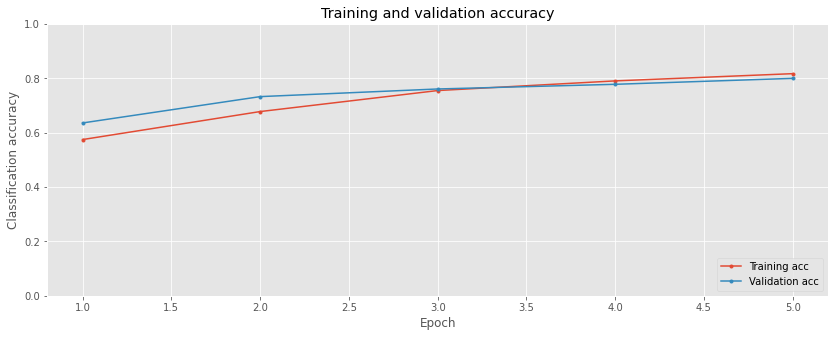

In [ ]:
# Plot the training and validation accuracy

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

history_dict = history.history

acc      = history_dict['accuracy']
val_acc  = history_dict['val_accuracy']
loss     = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14,5))
plt.plot(epochs, acc, marker='.', label='Training acc')
plt.plot(epochs, val_acc, marker='.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend(loc='lower right')
plt.ylim(0, 1);

In [ ]:
# Retrieve the embedding layer's weights from the trained model

weights = model.layers[1].get_weights()[0]

In [ ]:
# Save the word Embeddings to tsv files
# Two files: 
#     one contains the embedding labels (meta.tsv),
#     one contains the embeddings (vecs.tsv)

import io
from os import path

out_v = io.open(path.join('/content/drive/MyDrive', 'vecs.tsv'), 'w', encoding='utf-8')
out_m = io.open(path.join('/content/drive/MyDrive', 'meta.tsv'), 'w', encoding='utf-8')

k = 0

for word, token in imdb_word_index.items():
    if k != 0:
        out_m.write('\n')
        out_v.write('\n')
    
    out_v.write('\t'.join([str(x) for x in weights[token]]))
    out_m.write(word)
    k += 1
    
out_v.close()
out_m.close()
# beware large collections of embeddings!

---
<a id="coding_tutorial_5"></a>
## Recurrent neural network layers

#### Initialize and pass an input to a SimpleRNN layer

In [ ]:
# Create a SimpleRNN layer and test it

simple_rnn = tf.keras.layers.SimpleRNN(units = 16)

In [ ]:
# Note that only the final cell output is returned

sequence = tf.constant([[[1.,1.],[2.,2.],[-56.,100.]]])

layer_output = simple_rnn(sequence)
layer_output

<tf.Tensor: shape=(1, 16), dtype=float32, numpy=
array([[ 1.       ,  1.       ,  1.       , -1.       ,  1.       ,
        -0.9958265,  1.       ,  1.       , -1.       ,  0.9999996,
         1.       , -1.       ,  1.       ,  1.       ,  1.       ,
        -1.       ]], dtype=float32)>

#### Load and transform the IMDB review sentiment dataset

In [ ]:
# A function to load and preprocess the IMDB dataset

def get_and_pad_imdb_dataset(num_words=10000, maxlen=None, index_from=2):
    from tensorflow.keras.datasets import imdb

    # Load the reviews
    (x_train, y_train), (x_test, y_test) = imdb.load_data(path='imdb.npz',
                                                          num_words=num_words,
                                                          skip_top=0,
                                                          maxlen=maxlen,
                                                          start_char=1,
                                                          oov_char=2,
                                                          index_from=index_from)

    x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        maxlen=None,
                                                        padding='pre',
                                                        truncating='pre',
                                                        value=0)
    
    x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                           maxlen=None,
                                                           padding='pre',
                                                           truncating='pre',
                                                           value=0)
    return (x_train, y_train), (x_test, y_test)

In [ ]:
# Load the dataset

(x_train,y_train), (x_test, y_test) = get_and_pad_imdb_dataset(maxlen=250)


<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [ ]:
# A function to get the dataset word index

def get_imdb_word_index(num_words=10000, index_from=2):
    imdb_word_index = tf.keras.datasets.imdb.get_word_index(
                                        path='imdb_word_index.json')
    imdb_word_index = {key: value + index_from for
                       key, value in imdb_word_index.items() if value <= num_words-index_from}
    return imdb_word_index

In [ ]:
# Get the word index using get_imdb_word_index()

imdb_word_index = get_imdb_word_index()

#### Create a recurrent neural network model

In [ ]:
# Get the maximum index value

max_index_value = max(imdb_word_index.values())
embedding_dim = 16

In [ ]:
# Using Sequential, build the model:
# 1. Embedding.
# 2. LSTM.
# 3. Dense.

model = tf.keras.Sequential([
                     tf.keras.layers.Embedding(input_dim=max_index_value+1, output_dim= embedding_dim, mask_zero=True),
                     tf.keras.layers.LSTM(units = 16),
                     tf.keras.layers.Dense(units = 1, activation='sigmoid')
])

#### Compile and fit the model

In [ ]:
# Compile the model with binary cross-entropy loss

model.compile(loss = 'binary_crossentropy', metrics = ['accuracy'], optimizer = 'adam')

In [ ]:
# Fit the model and save its training history

history = model.fit(x_train, y_train, epochs = 1, validation_data=(x_test, y_test))

536/536 [==============================] - 302s 563ms/step - loss: 0.2726 - accuracy: 0.8929 - val_loss: 0.3053 - val_accuracy: 0.8758


#### Plot learning curves

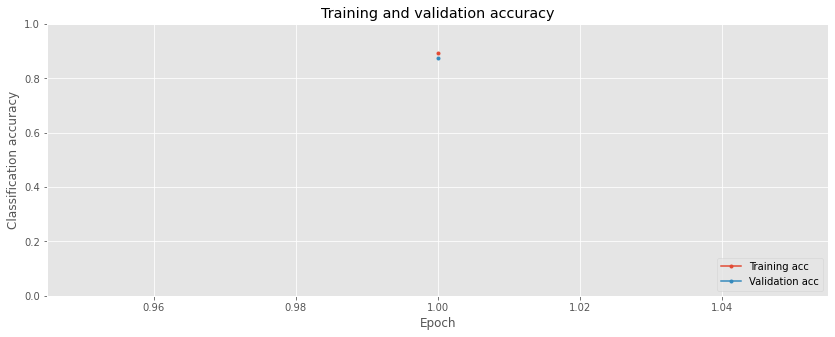

In [ ]:
# Plot the training and validation accuracy

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

history_dict = history.history

acc      = history_dict['accuracy']
val_acc  = history_dict['val_accuracy']
loss     = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14,5))
plt.plot(epochs, acc, marker='.', label='Training acc')
plt.plot(epochs, val_acc, marker='.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend(loc='lower right')
plt.ylim(0, 1);

#### Make predictions with the model

In [ ]:
# View the first test data example sentence
# (invert the word index)

inv_imdb_word_index = {val : key for key, val in imdb_word_index.items()}
first_review_list = [inv_imdb_word_index[index] for index in x_test[0] if index > 2]
first_review = ' '.join(first_review_list)
first_review

"please give this one a miss br br and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite so all you madison fans give this a miss"

In [ ]:
# Get the model prediction using model.predict()

model.predict(x_test[None,0,:])

array([[0.05665883]], dtype=float32)

In [ ]:
# Get the corresponding label

y_test[0]

0

---
<a id="coding_tutorial_6"></a>
## Stacked RNNs and the Bidirectional wrapper

#### Load and transform the IMDb review sentiment dataset

In [ ]:
# A function to load and preprocess the IMDB dataset

def get_and_pad_imdb_dataset(num_words=10000, maxlen=None, index_from=2):
    from tensorflow.keras.datasets import imdb

    # Load the reviews
    (x_train, y_train), (x_test, y_test) = imdb.load_data(path='imdb.npz',
                                                          num_words=num_words,
                                                          skip_top=0,
                                                          maxlen=maxlen,
                                                          start_char=1,
                                                          oov_char=2,
                                                          index_from=index_from)

    x_train = tf.keras.preprocessing.sequence.pad_sequences(x_train,
                                                        maxlen=None,
                                                        padding='pre',
                                                        truncating='pre',
                                                        value=0)
    
    x_test = tf.keras.preprocessing.sequence.pad_sequences(x_test,
                                                           maxlen=None,
                                                           padding='pre',
                                                           truncating='pre',
                                                           value=0)
    return (x_train, y_train), (x_test, y_test)

In [ ]:
# Load the dataset

(x_train, y_train), (x_test, y_test) = get_and_pad_imdb_dataset(num_words = 5000, maxlen=250)

<string>:6: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:155: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  x_train, y_train = np.array(xs[:idx]), np.array(labels[:idx])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/datasets/imdb.py:156: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 

In [ ]:
# A function to get the dataset word index

def get_imdb_word_index(num_words=10000, index_from=2):
    imdb_word_index = tf.keras.datasets.imdb.get_word_index(
                                        path='imdb_word_index.json')
    imdb_word_index = {key: value + index_from for
                       key, value in imdb_word_index.items() if value <= num_words-index_from}
    return imdb_word_index

In [ ]:
# Get the word index using get_imdb_word_index()

imdb_word_index = get_imdb_word_index(num_words = 5000)

#### Build stacked and bidirectional recurrent models

In [ ]:
# Get the maximum index value and specify an embedding dimension

max_index_value = max(imdb_word_index.values())
embedding_dim = 16

In [ ]:
# Using Sequential, build a stacked LSTM model via return_sequences=True

model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(input_dim=max_index_value+1, output_dim=embedding_dim, mask_zero=True),
                             tf.keras.layers.LSTM(units=32, return_sequences=True),
                             tf.keras.layers.LSTM(units=32, return_sequences=False),
                             tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [ ]:
# Using Sequential, build a bidirectional RNN with merge_mode='sum'

model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(input_dim=max_index_value+1, output_dim=embedding_dim, mask_zero = True),
                             tf.keras.layers.Bidirectional(layer=tf.keras.layers.LSTM(units=8), merge_mode='sum',
                                                           backward_layer=tf.keras.layers.GRU(units=8, go_backwards=True)),
                             tf.keras.layers.Dense(units=1, activation='sigmoid')
])

In [ ]:
# Create a model featuring both stacked recurrent layers and a bidirectional layer

model = tf.keras.Sequential([
                             tf.keras.layers.Embedding(input_dim=max_index_value+1, output_dim=embedding_dim, mask_zero=True),
                             tf.keras.layers.Bidirectional(layer = tf.keras.layers.LSTM(units=8, return_sequences=True), merge_mode='concat'),
                             tf.keras.layers.GRU(units=8, return_sequences=False),
                             tf.keras.layers.Dense(units=1, activation='sigmoid')
])

#### Compile and fit the model

In [ ]:
# Compile the model

model.compile(loss='binary_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
# Train the model, saving its history

history = model.fit(x_train, y_train, epochs=3, batch_size=32)

Epoch 1/3
  7/536 [..............................] - ETA: 13:17 - loss: 0.6930 - accuracy: 0.4777

KeyboardInterrupt: ignored

In [ ]:
# Plot the training and validation accuracy

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

history_dict = history.history

acc      = history_dict['accuracy']
val_acc  = history_dict['val_accuracy']
loss     = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

plt.figure(figsize=(14,5))
plt.plot(epochs, acc, marker='.', label='Training acc')
plt.plot(epochs, val_acc, marker='.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Classification accuracy')
plt.legend(loc='lower right')
plt.ylim(0, 1);